In [82]:
from netdeployonnx.client.experiment_helper import (  # noqa: F403
    get_data_overview,
    load_results,
    math,
    np,
    pd,
    plt,
    sns,
    stats,
)
from collections import defaultdict


In [121]:
df = load_results("../../results.yaml")
list(df.keys())
df['experiment_idx'] = pd.factorize(df['experiment'])[0]
df['network_idx'] = pd.factorize(df['option_network_name'])[0]
df_filtered = df.drop(columns=[
    'experiment',
    'date',
    'samplepoints',
    'option_network_name'
    ])
for column_name in df_filtered.columns:
    # df_filtered[column_name] = pd.to_numeric(df_filtered[column_name])
    if df_filtered[column_name].dtype == 'bool':
        df_filtered[column_name] = df_filtered[column_name].astype('int64')

assert all(x in ['int64', 'float64'] for x in df_filtered.dtypes)
df['option_network_name'].unique()

array(['cifar10_short.onnx', 'cifar10.onnx',
       'ai85-bayer2rgb-qat8-q.pth.onnx', 'ai85-cifar10-qat8-q.pth.onnx',
       'ai85-cifar100-qat8-q.pth.onnx', 'ai85-kws20_v3-qat8-q.pth.onnx'],
      dtype=object)

In [134]:
weights = defaultdict(lambda: 0)
nice_network_names = defaultdict(lambda: "")

nice_network_names.update({
    'cifar10_short.onnx':"CIFAR10 (short=5ly)",
    'cifar10.onnx':"CIFAR10",
    'ai85-bayer2rgb-qat8-q.pth.onnx':"Bayer2RGB",
    'ai85-cifar10-qat8-q.pth.onnx':"CIFAR10 quant.",
    'ai85-cifar100-qat8-q.pth.onnx':"CIFAR100 quant.",
    'ai85-faceid_112-qat-q.pth.onnx':"FACEID-112 quant.",
    'ai85-kws20_v3-qat8-q.pth.onnx':"KWS20v3 quant.",
})

weights.update({
    # "cifar10_short.onnx": 49152,
    # "cifar10.onnx": 302606,
    # "ai85-bayer2rgb-qat8-q.pth.onnx": 184,
    # "ai85-cifar10-qat8-q.pth.onnx": 303054,
    # "ai85-cifar100-qat8-q.pth.onnx": 349224,
    # "ai85-faceid_112-qat-q.pth.onnx": 893585,
    # "ai85-kws20_v3-qat8-q.pth.onnx": 170127,
    "cifar10_short.onnx": 42944,
    "cifar10.onnx": 302602,
    "ai85-bayer2rgb-qat8-q.pth.onnx": 99,
    "ai85-cifar10-qat8-q.pth.onnx": 302602,
    "ai85-cifar100-qat8-q.pth.onnx": 348772,
    "ai85-faceid_112-qat-q.pth.onnx": 892016,
    "ai85-kws20_v3-qat8-q.pth.onnx": 170125,
})

nice_colnames = {
    '_check_model': "Model validation",
    'layout_transform':'Transforming the network',
    'compile_instructions':'Compilation of  Instructions',
    'execute':'Execution and device information transfer',
    }
nice_metrics = {
    'inference': "Inference",
    'weights_loading': "Loading of Weights",
    'input_loading': "Loading of Inputs",
}

/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


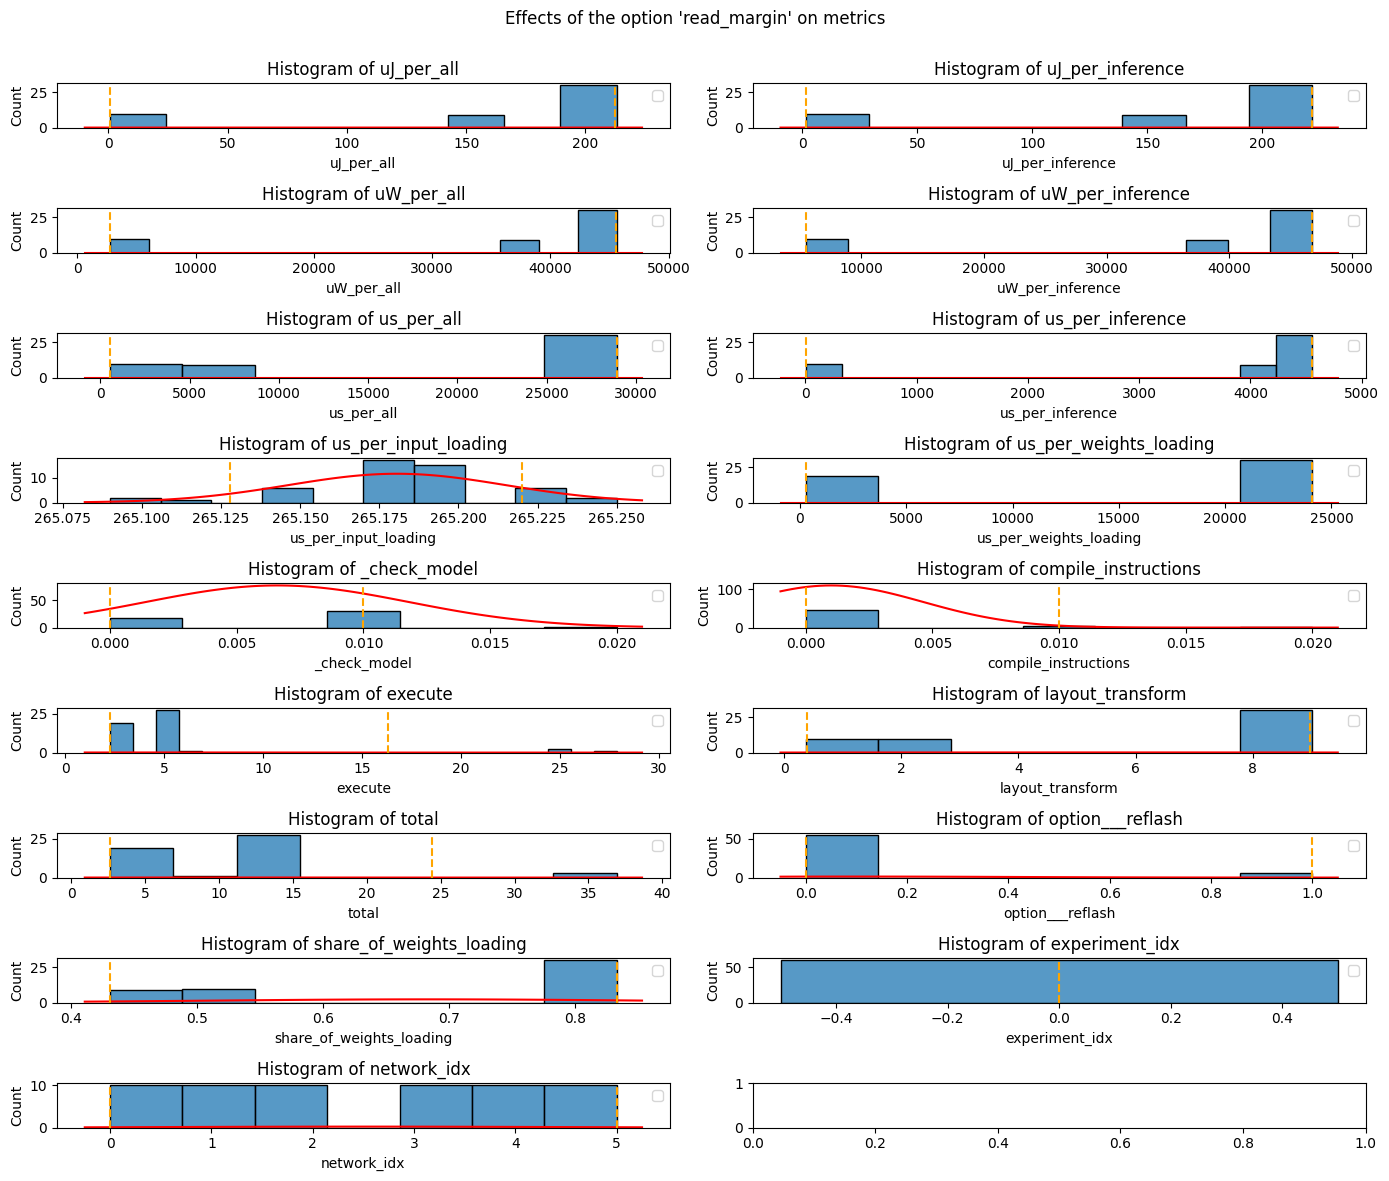

In [123]:
quantil = 0.95

def check_for_flash_vs_noflash():
    # can i see a difference between with and without flashing
    grouped = df.groupby(['experiment_idx', 'option___reflash']).mean('deploy').reset_index()
    # relative = grouped.pct_change()
    grouped_with_zero = [col for col in grouped.columns if (grouped[col] == 0).any()]
    relative_diffs = grouped.drop(columns=grouped_with_zero).pct_change().dropna()
    assert all(relative_diffs < 0.01) # diff is smaller than 1%

check_for_flash_vs_noflash()
data_overview_plot = get_data_overview(df_filtered.drop(columns=['uJ_per_input_loading', 'uJ_per_weights_loading','uW_per_input_loading', 'uW_per_weights_loading']))


## Metrics between nets and flashing vs not flashing

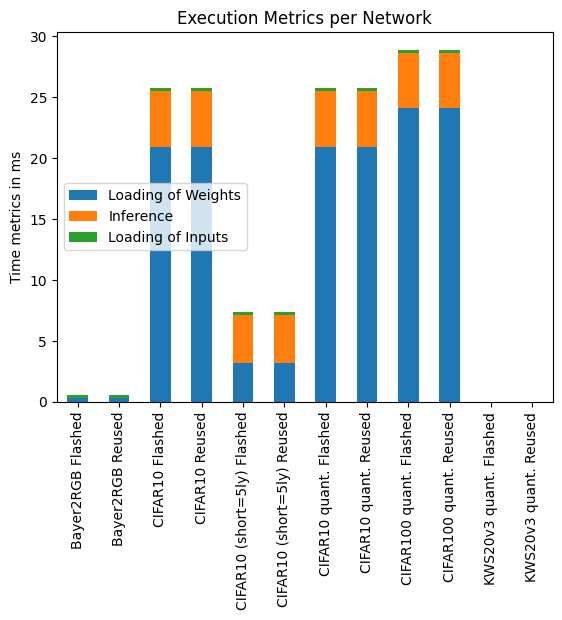

In [137]:
# print(df_filtered.columns)
df_percents = pd.DataFrame()
df_percents['Option'] = df_filtered['option___reflash'].apply(lambda x: 'Flashed' if x else 'Reused')
df_percents['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
for k in ['inference','weights_loading', 'input_loading']:
    df_percents[nice_metrics[k]] = df_filtered[f'us_per_{k}'] #/ df_filtered['us_per_all']

df_percents_indexed = df_percents.set_index(['Network', 'Option']).apply(lambda x: x / 1000, axis=1)
df_percents_grouped = df_percents_indexed.groupby(['Network', 'Option']).mean()

df_percents_grouped.index = [f'{net} {option}' for net, option in df_percents_grouped.index]


# Plot the stacked bar chart
df_percents_grouped[[nice_metrics[k] for k in ['weights_loading', 'inference','input_loading', ]]].plot(kind='bar', stacked=True)

plt.ylabel('Time metrics in ms')
plt.title('Execution Metrics per Network')
plt.show()


## Metrics between nets and flashing vs not flashing

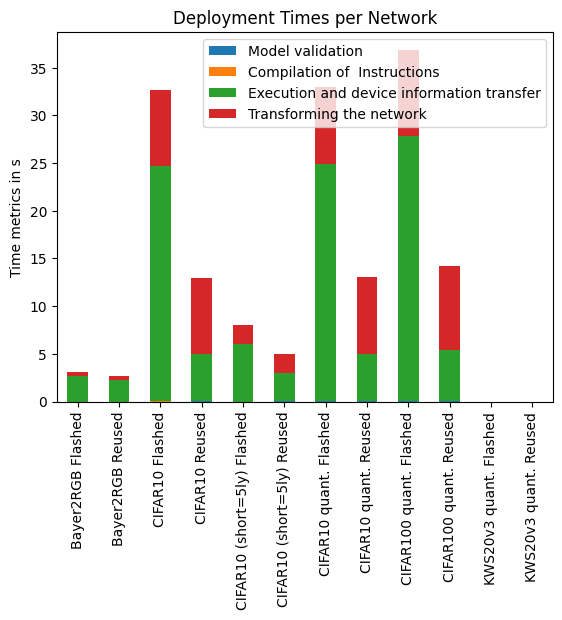

In [133]:
# print(df_filtered.columns)
df_percents = pd.DataFrame()
df_percents['Option'] = df_filtered['option___reflash'].apply(lambda x: 'Flashed' if x else 'Reused')
df_percents['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
for k in ['_check_model', 'compile_instructions', 'execute', 'layout_transform']:
    df_percents[nice_colnames[k]] = df_filtered[k] #/ df_filtered['us_per_all']

df_percents_indexed = df_percents.set_index(['Network', 'Option'])
df_percents_grouped = df_percents_indexed.groupby(['Network', 'Option']).mean()

df_percents_grouped.index = [f'{net} {option}' for net, option in df_percents_grouped.index]


# Plot the stacked bar chart
df_percents_grouped.plot(kind='bar', stacked=True)

plt.ylabel('Time metrics in s')
plt.title('Deployment Times per Network')
plt.show()


Text(0.5, 1.0, 'constant weight loading scheme')

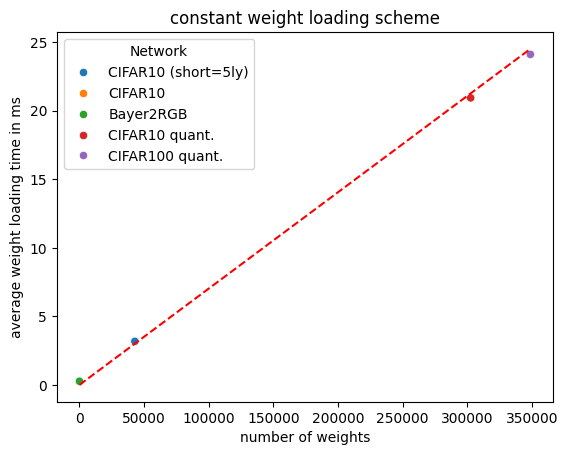

In [126]:
# plot time per weight as a plot with the 'network_name' as hue
df_per_weights = df_filtered.copy().dropna(subset=['us_per_weights_loading'])
df_per_weights['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_per_weights['weight_count'] = df['option_network_name'].apply(lambda x: weights[x])
df_per_weights['us_per_weights_loading'] = df_per_weights['us_per_weights_loading'].apply(lambda x: x/1000)
df_per_weights['perform'] = df_per_weights['weight_count'] / df_per_weights['us_per_weights_loading']

sns.scatterplot(data=df_per_weights, x='weight_count', y='us_per_weights_loading', hue='Network',)

plt.plot(np.linspace( df_per_weights['weight_count'].min(),  df_per_weights['weight_count'].max(), 100),
         1.0/(df_per_weights[df_per_weights['perform'] > 1000]['perform']).mean() * np.linspace(df_per_weights['weight_count'].min(), df_per_weights['weight_count'].max(), 100),
         color='red', linestyle='--', label='Slope = 1/14')
plt.xlabel("number of weights")
plt.ylabel("average weight loading time in ms")
plt.title('constant weight loading scheme')

# mean = (df_per_weights[df_per_weights['perform'] > 1000]['perform']).mean() # 14232
# df_per_weights[['weight_count', 'Network', 'us_per_weights_loading','perform']]

In [127]:
option = 'option_GCR.pclkdiv.cnnclkdiv'

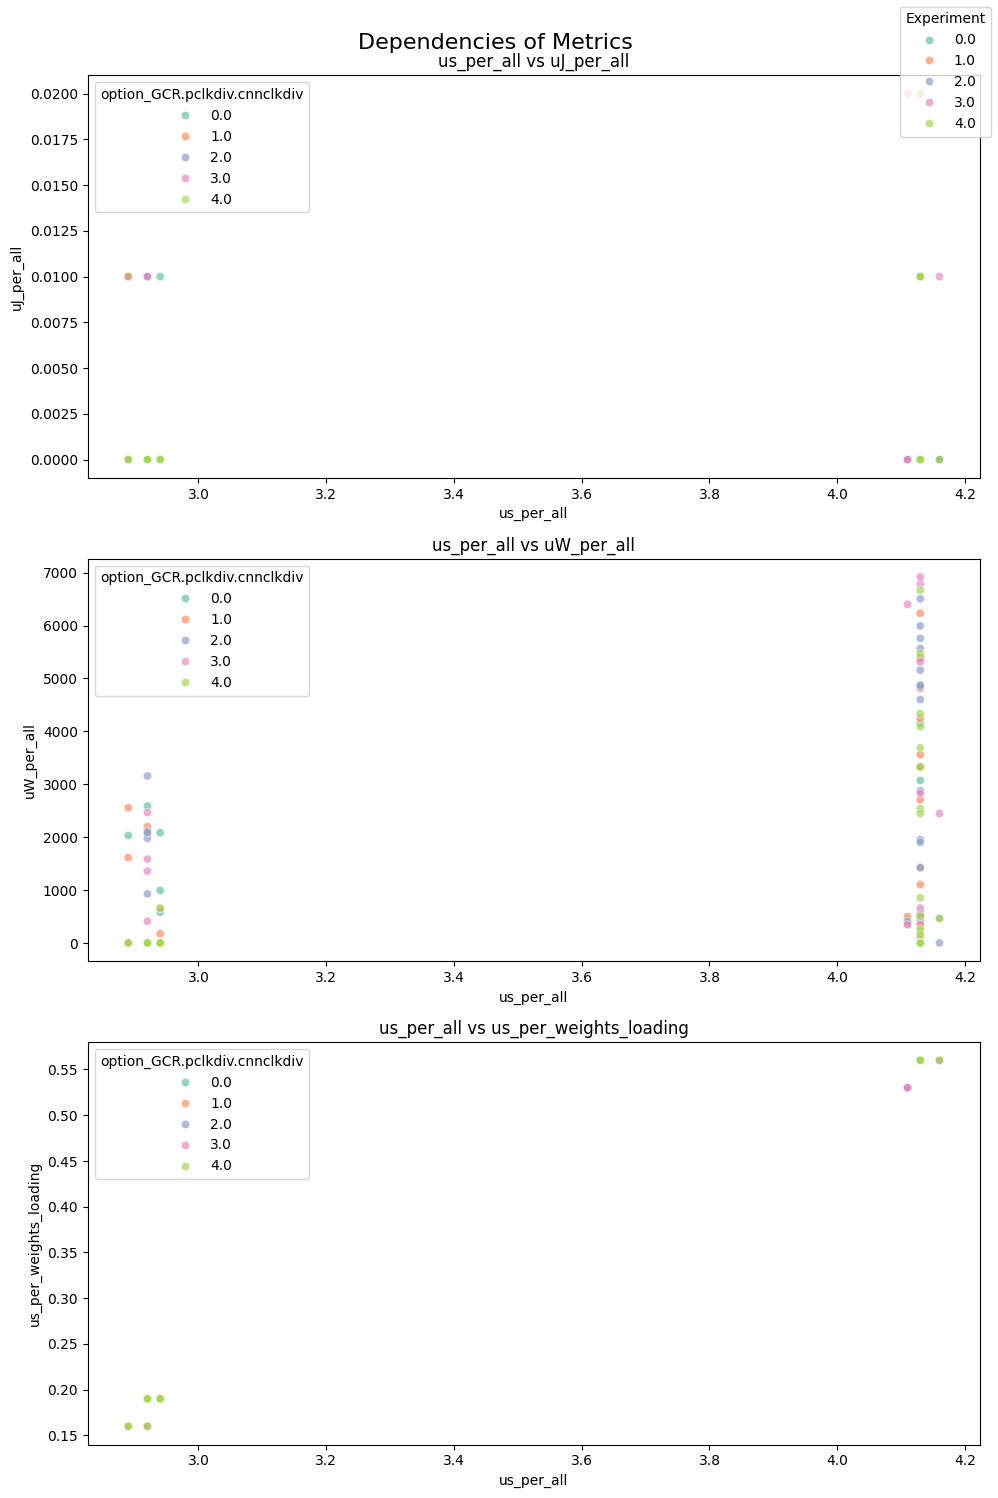

In [ ]:
# Define the list of metric pairs for plotting
metric_pairs = [
    ('us_per_all', 'uJ_per_all'),
    ('us_per_all', 'uW_per_all'),
    ('us_per_all', 'us_per_weights_loading'),
]

# Set up subplots based on the number of pairs
fig, axes = plt.subplots(len(metric_pairs), 1, figsize=(10, 5 * len(metric_pairs)))  # Adjust as needed

# Plot each pair
for i, (x_metric, y_metric) in enumerate(metric_pairs):
    sns.scatterplot(data=df_filtered, x=x_metric, y=y_metric, hue=option, ax=axes[i], palette='Set2', alpha=0.7)
    # Set title for each subplot
    axes[i].set_title(f'{x_metric} vs {y_metric}')

# Create a global legend using handles and labels from the first axis
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first axis
fig.legend(handles, labels, loc='upper right', title='Experiment')

# Set the overall title for the figure
fig.suptitle('Dependencies of Metrics', fontsize=16)

plt.tight_layout()
plt.show()

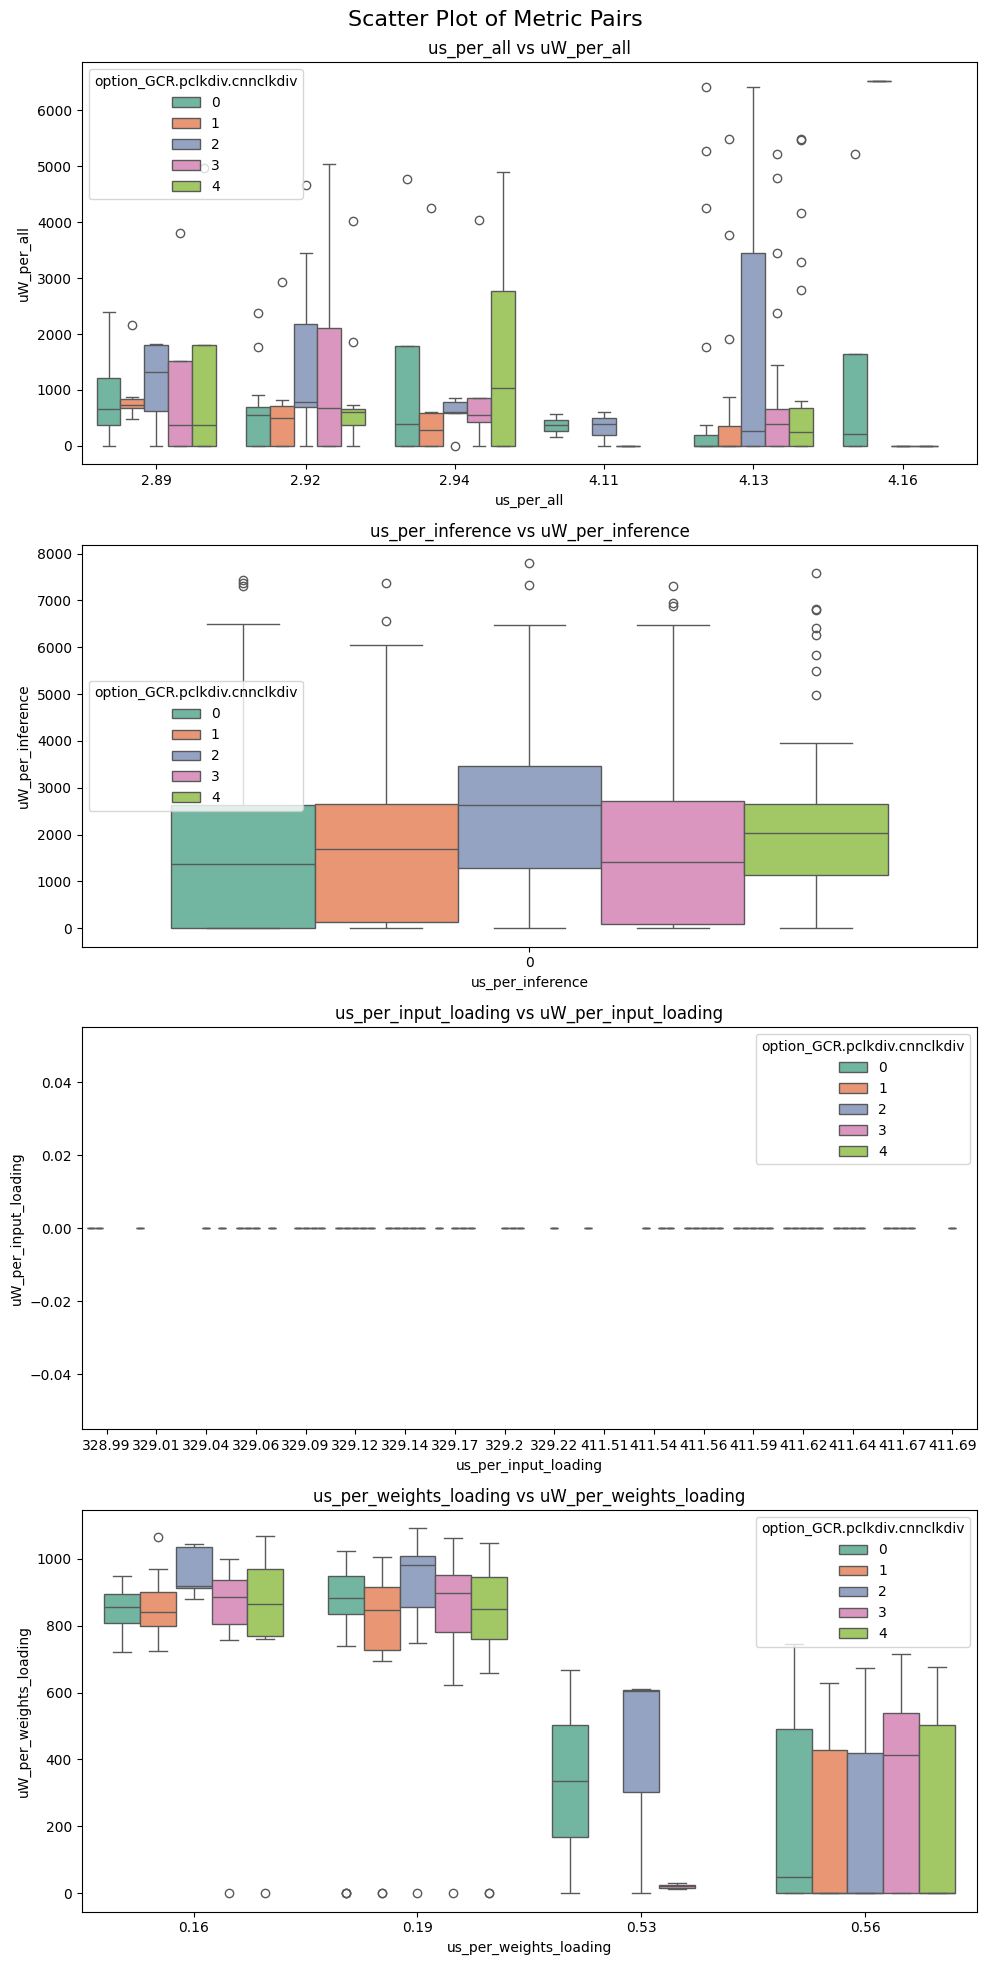

In [ ]:
# Define the list of metric pairs for plotting
metric_pairs = [
    ('us_per_all', 'uW_per_all'),
    ('us_per_inference', 'uW_per_inference'),
    ('us_per_input_loading', 'uW_per_input_loading'),
    ('us_per_weights_loading', 'uW_per_weights_loading'),
]
# Set up subplots based on the number of pairs
fig, axes = plt.subplots(len(metric_pairs), 1, figsize=(10, 5 * len(metric_pairs)))  # Adjust height as needed

# Plot each pair
for i, (x_metric, y_metric) in enumerate(metric_pairs):
    ax1 = axes[i]  # Get the current subplot axis

    # Check if y_metric is a tuple (for dual y-axes)
    if isinstance(y_metric, tuple):
        # Plot the first y metric on the primary y-axis
        y1 = y_metric[0]
        sns.boxplot(
            data=df_filtered, x=x_metric, y=y1, ax=ax1,
            hue=option,
            # label=y1,
            palette='Set2',
            # alpha=0.7,
            # multiple='dodge',
            )

        # Create a second y-axis for the second metric
        ax2 = ax1.twinx()  # Create a twin y-axis
        y2 = y_metric[1]
        sns.boxplot(
            data=df_filtered, x=x_metric, y=y2, ax=ax2,
            hue=option,
            # label=y2,
            palette='Set2',
            # alpha=0.7,
            # multiple='dodge',
            )
    else:
        # Plot the single y metric on the primary y-axis
        sns.boxplot(
            data=df_filtered, x=x_metric, y=y_metric, ax=ax1,
            hue=option,
            # label=y_metric,
            palette='Set2',
            # alpha=0.7,
            # multiple='dodge',
            )

    # Set title for each subplot
    ax1.set_title(f'{x_metric} vs {y_metric if not isinstance(y_metric, tuple) else y_metric[0]}')

# Set title for the overall plot
plt.suptitle('Scatter Plot of Metric Pairs', fontsize=16)

# Create a global legend using handles and labels from the plot
# handles, labels = plt.gca().get_legend_handles_labels()  # Get handles and labels from the current axis
# plt.legend(handles, labels, title='Experiment', loc='upper right')
plt.tight_layout(rect=[0,0,1,0.99])
plt.show()

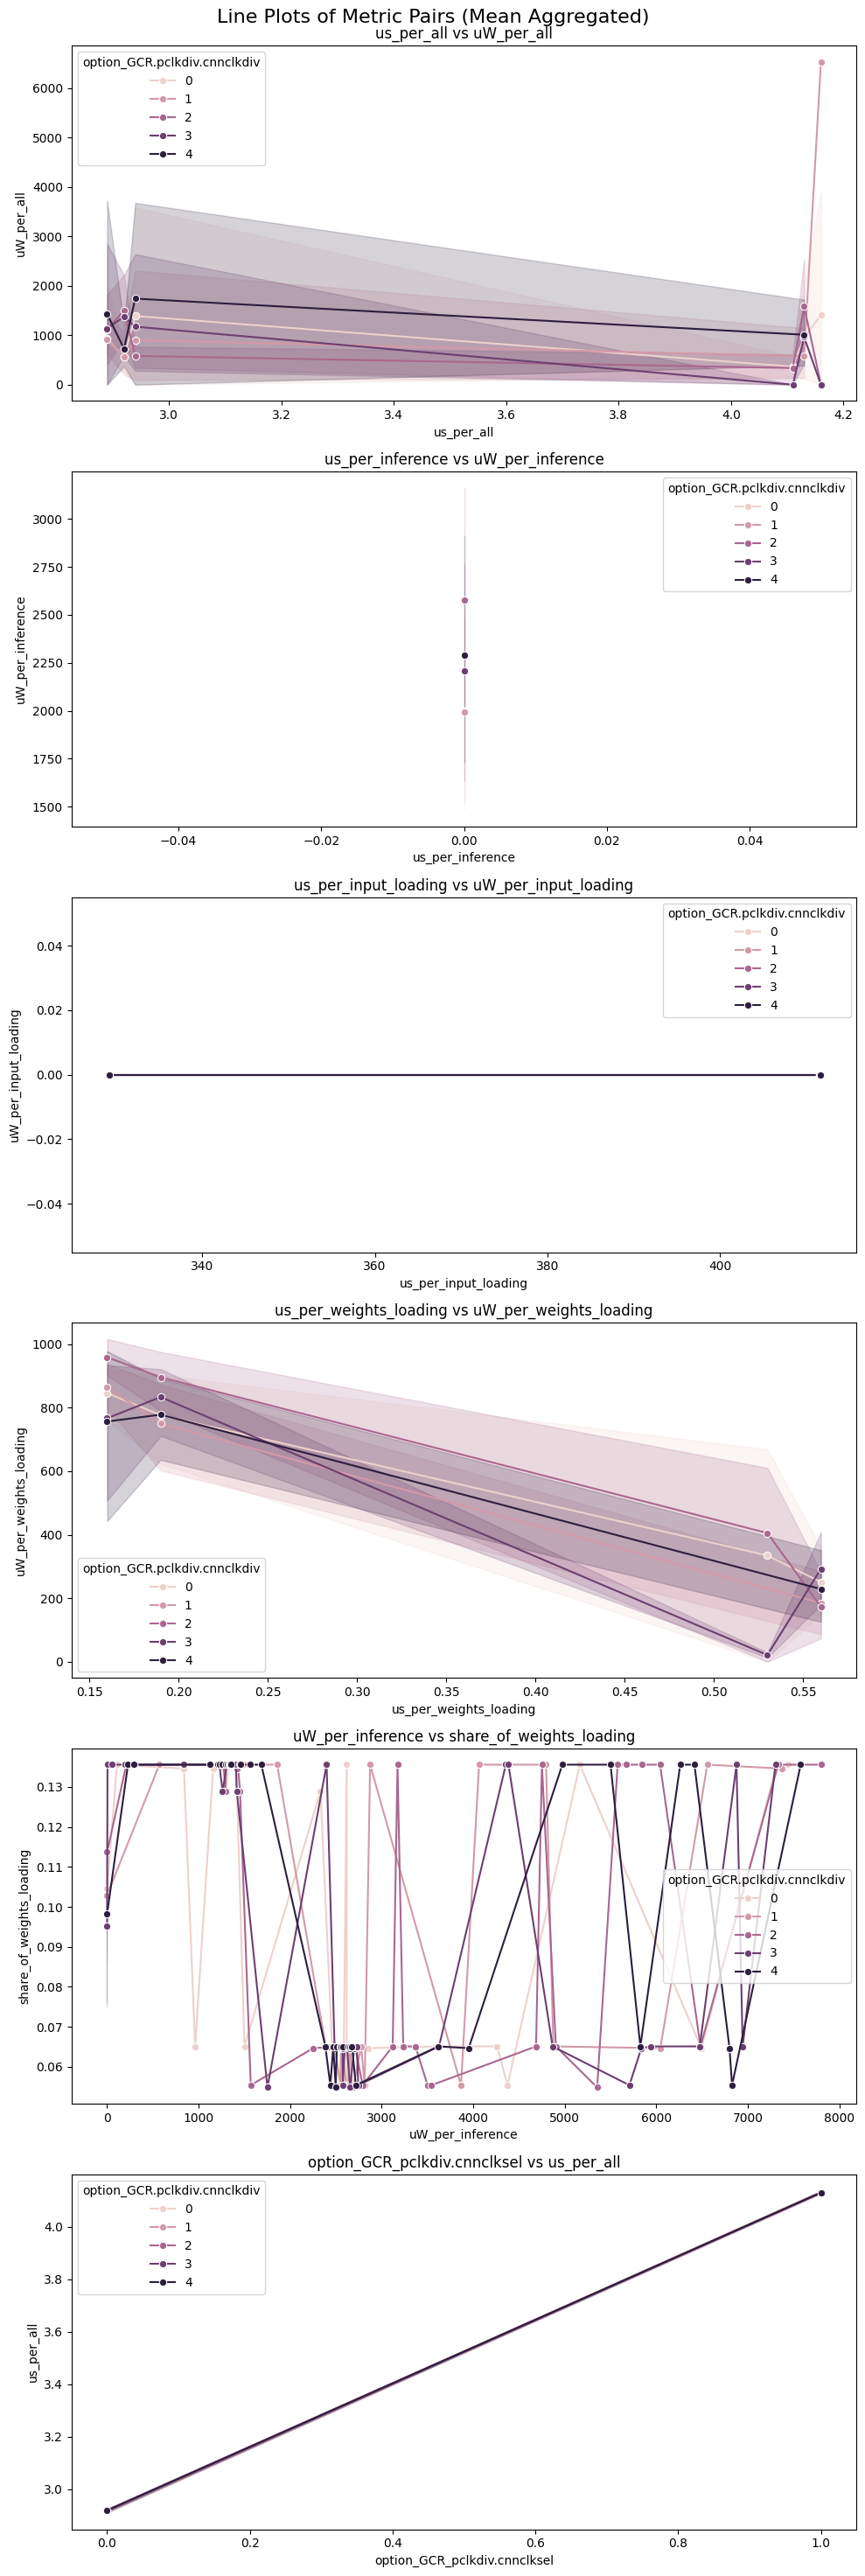

In [ ]:
metric_pairs2 = metric_pairs +[
    ('uW_per_inference', 'share_of_weights_loading'),
    ('option_GCR_pclkdiv.cnnclksel', 'us_per_all'),
]

# Set up the plot
fig, axes = plt.subplots(len(metric_pairs2), 1, figsize=(10, 5 * len(metric_pairs2)))  # Adjust height as needed

# Plot each pair
for i, (x_metric, y_metric) in enumerate(metric_pairs2):
    ax = axes[i]  # Get the current subplot axis
    
    # Group by the x metric and calculate the mean for the y metric(s)
    if isinstance(y_metric, tuple):
        y1 = y_metric[0]
        y2 = y_metric[1]

        # Group and calculate means
        mean_df1 = df_filtered.groupby(x_metric, as_index=False)[y1].mean()
        mean_df2 = df_filtered.groupby(x_metric, as_index=False)[y2].mean()

        # Plot the first metric
        sns.lineplot(data=mean_df1, x=x_metric, y=y1, ax=ax, hue=option, marker='o')
        
        # Plot the second metric on the same axis
        sns.lineplot(data=mean_df2, x=x_metric, y=y2, ax=ax, hue=option, marker='o')
        
    else:
        if y_metric == option:
            # Group and calculate means
            mean_df = df_filtered.groupby([x_metric, option], as_index=False)[y_metric].mean()
            sns.lineplot(data=mean_df, x=x_metric, y=y_metric, ax=ax, marker='o')
        else:
            # Group and calculate means
            mean_df = df_filtered.groupby([x_metric, option], as_index=False)[y_metric].mean()
            sns.lineplot(data=df_filtered, x=x_metric, y=y_metric, ax=ax, hue=option, marker='o')

    # Set title for each subplot
    ax.set_title(f'{x_metric} vs {y_metric if not isinstance(y_metric, tuple) else y_metric[0]}')

# Set the overall title for the figure
fig.suptitle('Line Plots of Metric Pairs (Mean Aggregated)', fontsize=16)

# # Create a global legend using handles and labels from the first subplot
# handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot
# fig.legend(handles, labels, title='Metrics', loc='upper right')

plt.tight_layout(rect=[0,0,1,0.99])
plt.show()